In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np

# PyMC for Bayesian statistical modeling and probabilistic machine learning
import pymc as pm
# ArviZ for exploratory analysis of Bayesian models
import arviz as az

# Matplotlib and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

(1370, 58)


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


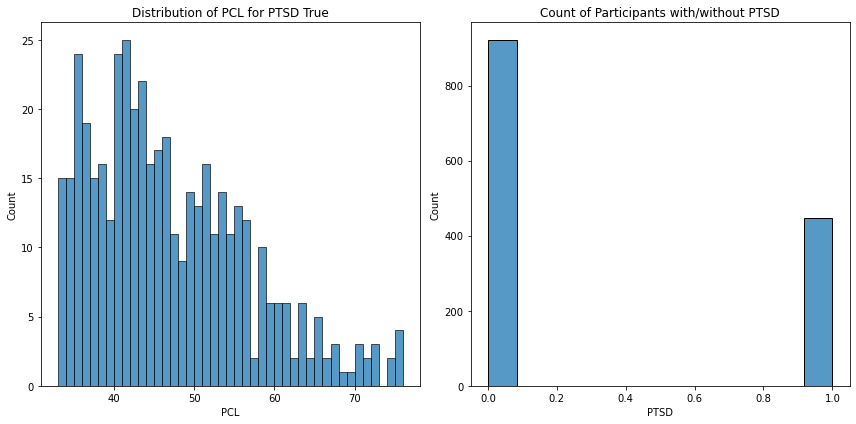

In [2]:
# Read data into DataFrames
df4 = pd.read_csv('../Data/clean/Cohort4Clean.csv')
df5 = pd.read_csv('../Data/clean/Cohort5Clean.csv')
pics = pd.read_csv('../pics/pics.csv')

# Concatenate df4 and df5 to create a combined DataFrame
df = pd.concat([df4,df5])

# Drop duplicate rows based on the 'ID' column
df = df.drop_duplicates(subset=['ID'])

# Print the shape (number of rows and columns) of the combined and deduplicated DataFrame
print(df.shape)


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram of the 'PCL' column for rows where 'PTSD' is True on the first subplot
sns.histplot(data=df[df['PTSD']==True], x='PCL', binwidth=1, ax=axes[0])
axes[0].set_title('Distribution of PCL for PTSD True')

# Plot the histogram of the 'PTSD' column (showing counts of 1/0) on the second subplot
sns.histplot(df.PTSD, ax=axes[1])
axes[1].set_title('Count of Participants with/without PTSD')

# Display the plots
plt.tight_layout()  # Adjusts spacing between subplots for better layout
plt.show()


original file: (47950, 9) clean file: (47433, 9)


<AxesSubplot:xlabel='scale_rating', ylabel='rating'>

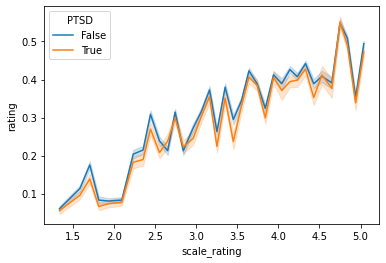

In [3]:
# Transform the DataFrame 'df' from wide to long format using 'melt'
# 'ID', 'PTSD', 'A', 'EmotionalNumbing', and 'PHQ' columns are kept as identifiers
# The values from columns 3 to 43 are reshaped into two columns: 'pic' (variable) and 'rating' (value)
df_long = pd.melt(df, id_vars=['ID','PTSD','A','EmotionalNumbing','PHQ'], 
                  value_vars=list(df.columns[3:43]),
                  var_name='pic', 
                  value_name='rating')

# Merge 'df_long' with the 'pics' DataFrame on the 'pic' column
# This operation adds information from 'pics' to 'df_long' based on picture names
# The merged DataFrame is then sorted by 'PTSD' and 'ID'
df_long = df_long.merge(pics, left_on='pic', right_on='pic').sort_values(['PTSD','ID'])

# Scale the 'rating' column by dividing each value by 100
df_long['rating'] = df_long['rating']/100

# Create a new column 'scale_rating' by copying values from 'NAPSr' column
df_long['scale_rating'] = df_long['NAPSr']

# Filter the DataFrame to keep only Neutral to negative pictures
df_long = df_long[df_long['scale_rating']<5.5].reset_index(drop=True)

# Remove rows from 'df_long' where 'rating' has missing (NaN) values
# Store the resulting DataFrame in 'df_long_c'
df_long_c = df_long.dropna(subset='rating').reset_index(drop=True)

# Print the shapes (number of rows and columns) of the original and cleaned DataFrames
# This provides a quick comparison of how many rows were dropped due to missing values in the 'rating' column
print("original file:", df_long.shape, "clean file:", df_long_c.shape)

# Plot the data using Seaborn's lineplot
# The x-axis represents 'scale_rating', the y-axis represents 'participants rating', and data points are colored based on the 'pPTSD' diagnosis
sns.lineplot(data=df_long, x='scale_rating', y='rating', hue='PTSD')

## Define models 

In [4]:
def linear(df_all, idx, n_subs):
    """
    Bayesian hierarchical model using a simple linear regression.
    
    Parameters:
    - df_all: DataFrame containing data.
    - idx: Index for hierarchical grouping.
    - n_subs: Number of subjects/groups.
    
    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define a probabilistic model using PyMC
    with pm.Model() as linear:
        
        # Define priors for the intercept and slope of the linear regression
        intercept = pm.HalfNormal('intercept', .2, shape = n_subs)  # HalfNormal prior for intercept with scale of 0.2
        slope = pm.HalfNormal('slope', .5, shape = n_subs)          # HalfNormal prior for slope with scale of 0.5
        
        # Define prior for standard deviation of observations
        eps = pm.Exponential('eps', 1)
        
        # Define the linear regression model
        y_hat = intercept[idx] + slope[idx] * df_all['scale_rating'].values

        # Define likelihood function using observed data
        rating = pm.Normal('rating', y_hat, eps, observed=df_all.rating)

        # Sample from the posterior distribution
        trace = pm.sample() 

    return trace

In [5]:
def pl5_hyper(df_all, idx, n_sub):
    """
    Bayesian hierarchical model using 5-Parameter Logistic (5PL) regression.
    
    Parameters:
    - df_all: DataFrame containing data.
    - idx: Index for hierarchical grouping.
    - n_sub: Number of subjects/groups.
    
    Returns:
    - trace: Samples from the posterior distribution.
    """
    
  
    # Define a probabilistic model using PyMC
    with pm.Model() as five_PL:
        
        a1   = pm.TruncatedNormal('a1',   2, 1, lower =  1) # Truncated Normal hyperprior for 'a1'
        a2   = pm.Normal('a2',           10, 1            ) # Normal hyperprior for 'a2'
        mu_b = pm.TruncatedNormal('mu_b', 2, 1, lower =  1) # Truncated Normal hyperprior for mean 'b'
        mu_c = pm.TruncatedNormal('mu_c', 2, 1, lower = .5) # Truncated Normal hyperprior for mean 'c'
        mu_d = pm.TruncatedNormal('mu_d', 2, 1, lower =  0) # Truncated Normal hyperprior for mean 'd'
        mu_g = pm.TruncatedNormal('mu_g', 4, 1, lower =  1) # Truncated Normal hyperprior for mean 'g'
        
        
        # Define priors for parameters of the 5PL regression
        a = pm.Beta('a',              a1, a2,                         shape = n_sub) # Beta distribution for lower asymptote
        b = pm.TruncatedNormal('b', mu_b,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for the slope
        c = pm.TruncatedNormal('c', mu_c,  1,  lower = .5, upper = 5, shape = n_sub) # Truncated Normal distribution for mid point
        d = pm.TruncatedNormal('d', mu_d,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for upper asymptote
        g = pm.TruncatedNormal('g', mu_g,  1,  lower = .8,            shape = n_sub) # Truncated Normal distribution for asymmetry factor
        

        # Define prior for standard deviation of observations
        eps = pm.Exponential('eps', 1)

        # Define the 5PL regression model   
        y_hat = d[idx] + ((a[idx]-d[idx])/(1+(df_all['scale_rating'].values/c[idx])**b[idx])**g[idx])

        # Define likelihood function using observed data
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.rating)

        # Sample from the posterior distribution
        trace = pm.sample()#tune = 2000, target_accept=0.95)

    return trace

## Compare groups

In [6]:
# Count the number of unique IDs (subjects) in the original 'df' DataFrame for which 'PTSD' is False/True (control/PTSD group)
n_control = len(df[df['PTSD']==False]['ID'].unique())
n_PTSD = len(df[df['PTSD']==True]['ID'].unique())

# Filter out rows from the cleaned DataFrame 'df_long_c' where 'PTSD' is False/Fales (control/PTSD group)
# and reset the index of the resulting DataFrame
df_c = df_long_c[df_long_c['PTSD']==False].reset_index(drop=True)
df_p = df_long_c[df_long_c['PTSD']==True].reset_index(drop=True)

# Add a new column 'sub_id' to the 'df_c'/'df_p' DataFrame that assigns a unique rank (ID) to each unique subject
# The 'rank' method with 'dense' ensures that every unique ID gets a unique rank without skipping numbers
df_c['sub_id'] = df_c['ID'].rank(method='dense')-1
df_p['sub_id'] = df_p['ID'].rank(method='dense')-1

# Extract the 'sub_id' column values from 'df_c' and 'df_p' and store them as integer lists
# These lists can later be used as indices for group-level hierarchical models or similar purposes
idx_c = df_c['sub_id'].values
idx_c = [int(i) for i in idx_c]

idx_p = df_p['sub_id'].values
idx_p = [int(i) for i in idx_p]

# Apply the 'linear' function 
trace_c_lin = linear(df_c, idx_c, n_control)
trace_p_lin = linear(df_p, idx_p, n_PTSD)

# Apply the 'pl5_hyper' function which  fits a 5-parameter logistic regression model to the data
trace_c_wh = pl5_hyper(df_c, idx_c, n_control)
trace_p_wh = pl5_hyper(df_p, idx_p, n_PTSD)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 342 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1978 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 650 seconds.


In [7]:
# Create a dictionary to hold the traces of the different models for comparison
# 'Linear' represents the linear model 
# 'hyper' represents the 5-parameter logistic regression model
compare_dict_c = {'Linear': trace_c_lin,
                  'hyper': trace_c_wh}

compare_dict_p = {'Linear': trace_p_lin,
                  'hyper': trace_p_wh,
                 }
# Use the 'compare' function from the ArviZ library to compare the models based on LOO
comp_c = az.compare(compare_dict_c)
comp_p = az.compare(compare_dict_p)

# Display the comparison results
comp_c

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hyper,0,14157.861999,1616.496221,0.000000,0.898498,167.370764,0.000000,True,log
Linear,1,12931.934227,1184.944737,1225.927773,0.101502,150.869189,55.559965,False,log


In [8]:
comp_p

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hyper,0,5711.366809,750.083442,0.000000,0.89463,104.636989,0.000000,False,log
Linear,1,5139.440835,572.991198,571.925974,0.10537,95.305152,37.854774,True,log


In [9]:
# Save the traces of the models to a NetCDF file
trace_c_lin.to_netcdf("../traces/trace_c_lin.nc")
trace_p_lin.to_netcdf("../traces/trace_p_lin.nc")
trace_c_wh.to_netcdf("../traces/trace_c_wc.nc")
trace_p_wh.to_netcdf("../traces/trace_p_wc.nc")

'../traces/trace_p_wc.nc'

The 5PL model explain the data better than a linear regression.

## Plot group comparison 

In [10]:
# Stack the chains and draws dimensions of the posterior into a single dimension named 'draws'
# This is for reshaping the data for subsequent analyses or visualizations
tr_c = trace_c_wh.posterior.stack(draws=("chain", "draw"))
tr_p = trace_p_wh.posterior.stack(draws=("chain", "draw"))

# Define a variable 'hpd' for visualizations
hpd = 5.5

In [11]:
def plot_hist(Control, PTSD, ax1_name, ax2_name, hpd=5.5, binw = .001):
    
    """
    Function to plot histograms comparing two groups (Control and PTSD).
    
    Parameters:
    - Control: Data for the control group
    - PTSD: Data for the PTSD group
    - ax1_name: Title for the first subplot
    - ax2_name: Title for the second subplot
    - hpd: Threshold for Highest Posterior Density interval (default is 5.5)
    - binw: Bin width for the histograms (default is 0.001)
    """
    
    # Compute the difference between the mean values of the control and PTSD groups
    difference = Control-PTSD
    
    # Calculate the percentiles for the differences, using the HPD
    q1, q2 = np.percentile(difference, [hpd, 100-hpd])
    
    # Filter out the data based on the lower (q1) and higher (q2) thresholds
    bottom_data = difference[difference <= q1]
    top_data = difference[difference >= q2]


    # Create a new figure with two subplots
    f, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the distributions of the provided datasets (e.g., lower asymptote values) for both groups in the first subplot
    sns.histplot(Control, binwidth=binw, ax=ax[0])
    sns.histplot(PTSD,    binwidth=binw, ax=ax[0])

    # Plot the distribution of the differences in the second subplot
    sns.histplot(data=difference, color='blue', ax=ax[1])

    # Update the bar colors in the difference histogram based on their position relative to the thresholds
    for bar in ax[1].patches:
        if bar.get_x() > q2:
            bar.set_color('orange')
        elif bar.get_x() < q1:
            bar.set_color('orange')
        else:
            bar.set_color('blue')

    # Add a reference line at zero in the difference histogram
    ax[1].axvline(0, color='black', linewidth=4)
    

    # Set titles for the subplots based on the provided names
    ax[0].set_title(ax1_name)
    ax[1].set_title(ax2_name)
    
    # Get the x and y limits of the first subplot
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()

    # Convert the desired 0.25 inches offset into a proportional x-axis distance
    fig_width_in_inches = f.get_figwidth()  # figure width in inches
    proportional_distance = 0.25 / fig_width_in_inches * (xlim[1] - xlim[0])

    # Set the text relative to the upper right corner
    text_offset_x = xlim[1] - proportional_distance
    text_offset_y_1 = ylim[1] - (ylim[1] * 0.1)  # 10% from the top for the first text
    text_offset_y_2 = ylim[1] - (ylim[1] * 0.2)  # 20% from the top for the second text

    text = 'TEC'
    ax[0].text(text_offset_x, text_offset_y_1, text, fontsize=18, color='#1f77b4', ha='right')
    text = 'pPTSD'
    ax[0].text(text_offset_x, text_offset_y_2, text, fontsize=18, color='orange', ha='right')
    
    print("mean: ", np.mean(difference), "89% HDPi: ",q1,q2)

mean:  -0.0036939548006574984 89% HDPi:  -0.009305787723466257 0.0018112183870335006


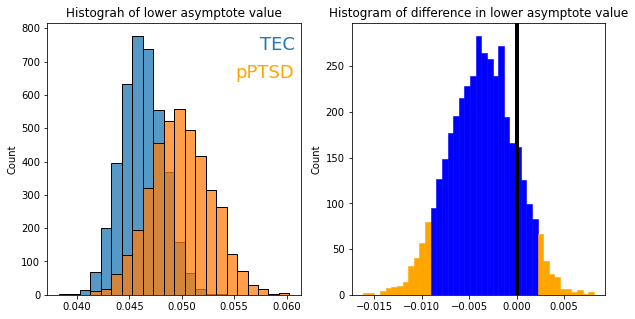

In [12]:
# Compute the mean value of the lower asymptote value
Control = np.mean(tr_c.a[:,:].values, axis = 0)
PTSD    = np.mean(tr_p.a[:,:].values, axis = 0)


# Use the 'plot_hist' function to visualize the distributions of the lower asymptote values 
# for both Control and PTSD groups as well as their differences.
plot_hist(Control, PTSD, 'Histograh of lower asymptote value', 'Histogram of difference in lower asymptote value')

mean:  -0.22923603386304836 89% HDPi:  -0.3141073340996348 -0.14610114781254643


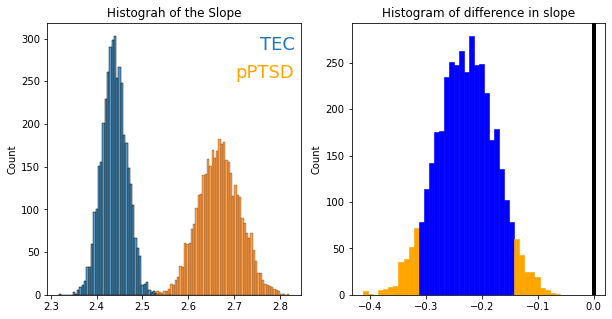

In [13]:
# Calculate the mean value of the slope parameter
Control = np.mean(tr_c.b[:,:].values, axis = 0)
PTSD    = np.mean(tr_p.b[:,:].values, axis = 0)

plot_hist(Control, PTSD, 'Histograh of the Slope', 'Histogram of difference in slope', binw=.005)

mean:  0.006304915617154909 89% HDPi:  -0.05085809001324515 0.0629202096548507


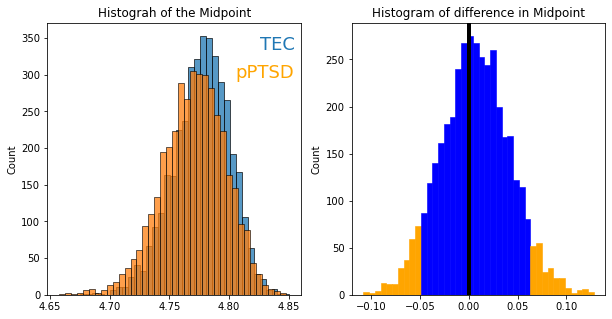

In [14]:
# Calculate the mean value of the mid point parameter
Control = np.mean(tr_c.c[:,:].values, axis = 0)
PTSD    = np.mean(tr_p.c[:,:].values, axis = 0)

plot_hist(Control, PTSD, 'Histograh of the Midpoint', 'Histogram of difference in Midpoint', binw=.005)

mean:  0.010523006585939356 89% HDPi:  -0.004950877797234262 0.02630216643927683


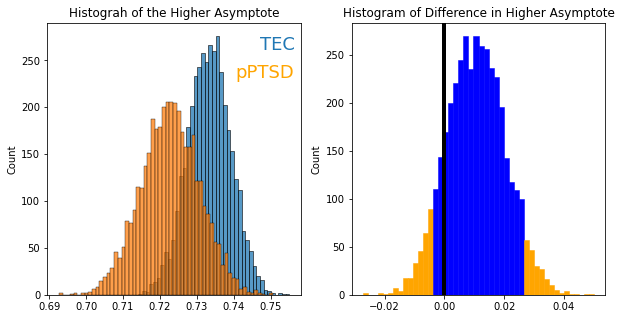

In [15]:
# Calculate the mean value of the higher asymptote parameter
Control = np.mean(tr_c.d[:,:].values, axis = 0)
PTSD    = np.mean(tr_p.d[:,:].values, axis = 0)

plot_hist(Control, PTSD, 'Histograh of the Higher Asymptote', 'Histogram of Difference in Higher Asymptote', binw=.001)

mean:  0.04563657083622387 89% HDPi:  -0.006540474517988161 0.09697081531790534


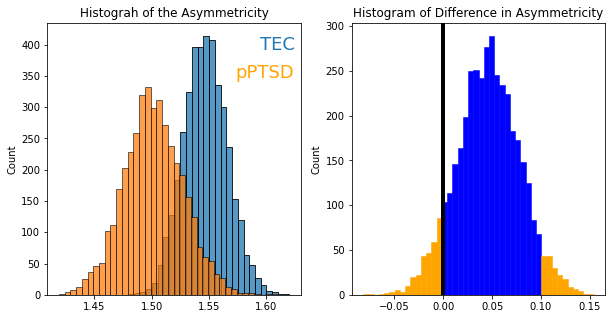

In [16]:
# Calculate the mean value of the Asymmetricity parameter
Control = np.mean(tr_c.g[:,:].values, axis = 0)
PTSD    = np.mean(tr_p.g[:,:].values, axis = 0)

plot_hist(Control, PTSD, 'Histograh of the Asymmetricity', 'Histogram of Difference in Asymmetricity', binw= 0.005)

A robust difference in the slope parameter.</br>
The PTSD group show higher slope, faster transition between rating something as a neutral and highly negative.

